In [74]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


In [75]:
PROCESSED_DATA_DIR = "../data/processed/"

train_df = pd.read_csv(os.path.join(PROCESSED_DATA_DIR,"train_processed.csv"))
train_df = train_df.drop(columns=["PassengerId"])
test_df = pd.read_csv(os.path.join(PROCESSED_DATA_DIR,"test_processed.csv"))
passenger_ids = test_df["PassengerId"]
test_df = test_df.drop(columns=["PassengerId","Survived"])

In [76]:
X = train_df.drop(columns=["Survived"])
y = train_df["Survived"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [77]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42, eval_metric='rmse'),
}

for name, model in models.items():
    model.fit(X_train, y_train)


In [78]:

for name, model in models.items():
    preds = model.predict(X_val)
    if preds.dtype.kind != 'i':  # i = integer
        preds = (preds > 0.5).astype(int)
    # print(f'preds = {preds}')
    print(f"{name} Accuracy: {accuracy_score(y_val, preds):.4f}")


Logistic Regression Accuracy: 0.8324
Random Forest Accuracy: 0.7989
XGBoost Accuracy: 0.7765


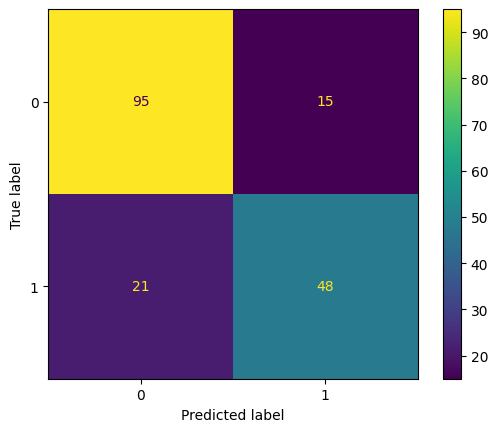

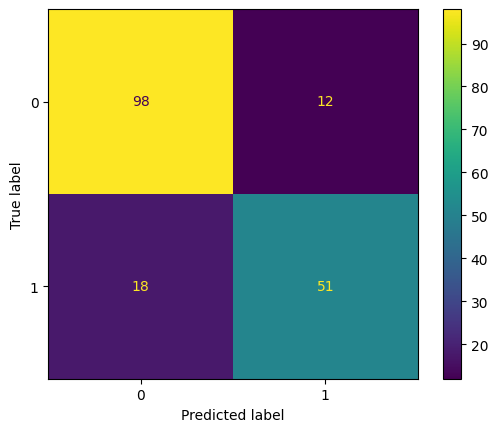

In [79]:
ConfusionMatrixDisplay.from_estimator(models["Random Forest"], X_val, y_val)
ConfusionMatrixDisplay.from_estimator(models["Logistic Regression"], X_val, y_val)

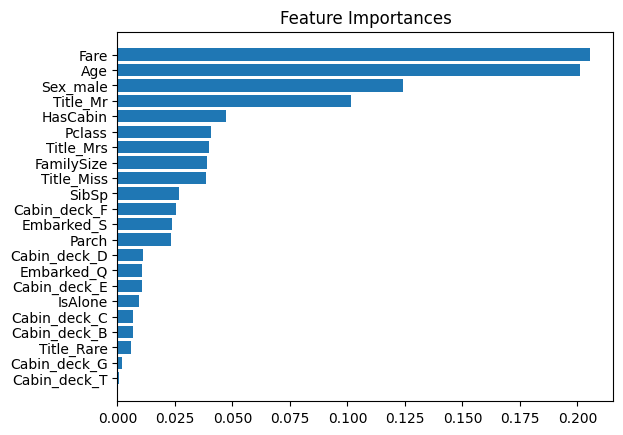

In [80]:
importances = models["Random Forest"].feature_importances_
indices = np.argsort(importances)[::-1]
plt.barh(X.columns[indices], importances[indices])
plt.gca().invert_yaxis()
plt.title("Feature Importances")
plt.show()


In [81]:
# Convert to Python sets for easy comparison
X_test = test_df
train_cols = set(X_train.columns)
test_cols = set(X_test.columns)

# Columns present in X_train but missing in X_test (Misalignment 1)
missing_in_test = train_cols.difference(test_cols)
print(f"Columns missing in X_test: {missing_in_test}")

# Columns present in X_test but NOT in X_train (Misalignment 2 - usually dropped by reindex)
extra_in_test = test_cols.difference(train_cols)
print(f"Columns extra in X_test: {extra_in_test}")
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

Columns missing in X_test: set()
Columns extra in X_test: set()


In [82]:
from joblib import dump

OUTPUT_DIR = "../outputs/"
os.makedirs(OUTPUT_DIR, exist_ok=True)
MODEL_DIR = os.path.join(OUTPUT_DIR, "models")
os.makedirs(MODEL_DIR, exist_ok=True)
SUBMISSION_DIR = os.path.join(OUTPUT_DIR, "submissions")
os.makedirs(SUBMISSION_DIR, exist_ok=True)


In [83]:
# Dictionary to store predictions
test_preds = {}

for name, model in models.items():
    preds = model.predict(X_test)
    # If model outputs floats (XGBRegressor, etc.), threshold at 0.5
    if preds.dtype.kind != 'i':  
        preds = (preds > 0.5).astype(int)
    test_preds[name] = preds

    # Save model
    dump(model, os.path.join(MODEL_DIR, f"{name.replace(' ', '_')}.joblib"))

    # Save submission CSV
    submission_df = pd.DataFrame({
        "PassengerId": passenger_ids,
        "Survived": preds
    })
    submission_df.to_csv(
        os.path.join(SUBMISSION_DIR, f"submission_{name.replace(' ', '_')}.csv"),
        index=False
    )
    print(f"{name} submission saved!")

Logistic Regression submission saved!
Random Forest submission saved!
XGBoost submission saved!


# TODO:  Fine and tunning 